In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import shap
from xgboost import XGBClassifier
from comet_ml import API
import cloudpickle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import src.features.build_features as FeaturesManager
import src.features.select_features as FeaturesSelector
import src.features.detect_outliers as OutliersManager
import src.visualization.visualize as VizManager
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [7]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)

X, y = data_df.drop(labels=['Is Goal'], axis=1), data_df['Is Goal']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

api = API()
workspace_name = "ift6758-a22-g08"

In [5]:
numerical_columns = [
    'Period seconds', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 
    'Speed From Previous Event', 'Change in Shot Angle', 
    'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
    'Elapsed time since Power Play', 'Last event elapsed time', 'Last event st_X', 'Last event st_Y', 
    'Last event distance', 'Last event angle']

nominal_columns = ['Shot Type', 'Strength', 'Shooter Side', 'Shooter Ice Position']
ordinal_columns = ['Period', 'Num players With', 'Num players Against', 'Is Empty', 'Rebound']

In [8]:
# SHAP Analysis to find the best features

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

# one-hot      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')

xbg = XGBClassifier(random_state=RANDOM_SEED)
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ("xbg", xbg)]
pipeline = Pipeline(steps=steps).fit(X_train, y_train)
    
# explain the model's predictions using SHAP
explainer = shap.Explainer(pipeline)
shap_values = explainer(X_train)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('fill_nan',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Shot Type', 'Strength',
                                                   'Shooter Side',
                                                   'Shooter Ice Position',
                                                   'Period', 'Num players With',
                                                   'Num players Against',
                                                   'Is Empty', 'Rebound']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Period seconds', 'st_X',
                                                   'st_Y', 'Shot distance',
                                                   'Shot an...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [7]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

NameError: name 'shap_values' is not defined

In [10]:



# Download the Adaboost / Anova
api.download_registry_model(workspace_name, "adaboost-anova", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Adaboost_Anova.pkl")
with open(pkl_filename, 'rb') as file:
    clf_adaboost_anova = cloudpickle.load(file)


# Download the Random Forest
api.download_registry_model(workspace_name, "randomforest-allfeatures", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "randomforest-allfeatures.pkl")
with open(pkl_filename, 'rb') as file:
    clf_random_forest = cloudpickle.load(file) 
    
# Download the Knn / Linear SVC
api.download_registry_model(workspace_name, "knn-lasso", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "KNN_Lasso.pkl")
with open(pkl_filename, 'rb') as file:
    clf_knn = cloudpickle.load(file)

    
# Download the Easy Ensemble / PCA
api.download_registry_model(workspace_name, "easyensemble-pca", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "EasyEnsemble_PCA.pkl")
with open(pkl_filename, 'rb') as file:
    clf_easyensemble_pca = cloudpickle.load(file)


# Download the Random Forest / Variance Threshold
api.download_registry_model(workspace_name, "forest-binning-shap-var", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Forest_Binning_SHAP_Var.pkl")
with open(pkl_filename, 'rb') as file:
    clf_forest_var = cloudpickle.load(file)

COMET INFO: Downloading registry model 'adaboost-anova', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'randomforest', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'knn-lasso', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'easyensemble-pca', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'forest-binning-shap-var', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unz

In [27]:
clf_random_forest

Pipeline(steps=[('fill_nan',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Shot Type', 'Strength',
                                                   'Shooter Side',
                                                   'Shooter Ice Position',
                                                   'Period', 'Num players With',
                                                   'Num players Against',
                                                   'Is Empty', 'Rebound']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Period seconds', 'st_X',
                                                   'st_Y', 'Shot distance',
                                                   'Shot an...
                                                   'Last event st_X',
                                                   'Last event st_Y',
                                                   'Last event distance',
                                                   'Last event angle'])])),
                ('one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 1, 2, 3])])),
                ('clf_forest',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_depth=10,
                                                max_features='log2',
                                                min_samples_split=8,
                                                n_estimators=82,
                                                random_state=42,
                                                sampling_strategy=0.5))])

In [52]:
api = API()
workspace_name = "ift6758-a22-g08"

import cloudpickle

# Download the Adaboost / Anova
api.download_registry_model(workspace_name, "adaboost-anova", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Adaboost_Anova.pkl")
with open(pkl_filename, 'rb') as file:
    clf_adaboost_anova = cloudpickle.load(file)
print('ADABOOST - PCA')
print(classification_report(y_valid, clf_adaboost_anova.predict(X_valid)))

# Download the Random Forest / All Features
api.download_registry_model(workspace_name, "randomforest-allfeatures", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "RandomForest_AllFeatures.pkl")
with open(pkl_filename, 'rb') as file:
    clf_random_forest = cloudpickle.load(file) 
print('RANDOM FOREST - ALL FEATURES')
print(classification_report(y_valid, clf_adaboost_anova.predict(X_valid)))

# Download the EasyEnsemble / PCA
api.download_registry_model(workspace_name, "easyensemble-pca", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "EasyEnsemble_PCA.pkl")
with open(pkl_filename, 'rb') as file:
    clf_easyensemble_pca = cloudpickle.load(file)
print('EASYENSEMBLE - PCA')
print(classification_report(y_valid, clf_easyensemble_pca.predict(X_valid)))

# Download the Knn / Linear SVC
api.download_registry_model(workspace_name, "knn-lasso", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "KNN_Lasso.pkl")
with open(pkl_filename, 'rb') as file:
    clf_knn = cloudpickle.load(file)
print('KNN - LINEAR SVC LASSO')
print(classification_report(y_valid, clf_knn.predict(X_valid)))

# Download the Random Forest / Shap-Binning-Variance Threshold
api.download_registry_model(workspace_name, "forest-binning-shap-var", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Forest_Binning_SHAP_Var.pkl")
with open(pkl_filename, 'rb') as file:
    clf_forest_var = cloudpickle.load(file)
print('RANDOM FOREST - SHAP/BINNING/VARIANCE THRESHOLD')
print(classification_report(y_valid, clf_forest_var.predict(X_valid)))


COMET INFO: Downloading registry model 'adaboost-anova', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


ADABOOST - PCA


COMET INFO: Downloading registry model 'randomforest-allfeatures', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     55434
         1.0       0.33      0.32      0.32      5738

    accuracy                           0.87     61172
   macro avg       0.63      0.63      0.63     61172
weighted avg       0.87      0.87      0.87     61172



COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


RANDOM FOREST - ALL FEATURES


COMET INFO: Downloading registry model 'easyensemble-pca', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     55434
         1.0       0.33      0.32      0.32      5738

    accuracy                           0.87     61172
   macro avg       0.63      0.63      0.63     61172
weighted avg       0.87      0.87      0.87     61172



COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


EASYENSEMBLE - PCA


COMET INFO: Downloading registry model 'knn-lasso', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...


              precision    recall  f1-score   support

         0.0       0.93      0.88      0.91     55434
         1.0       0.24      0.35      0.28      5738

    accuracy                           0.83     61172
   macro avg       0.58      0.62      0.59     61172
weighted avg       0.86      0.83      0.85     61172



COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


KNN - LINEAR SVC LASSO


COMET INFO: Downloading registry model 'forest-binning-shap-var', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...


              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     55434
         1.0       0.71      0.15      0.24      5738

    accuracy                           0.91     61172
   macro avg       0.81      0.57      0.60     61172
weighted avg       0.90      0.91      0.89     61172



COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


RANDOM FOREST - SHAP/BINNING/VARIANCE THRESHOLD
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     55434
         1.0       0.35      0.27      0.31      5738

    accuracy                           0.88     61172
   macro avg       0.64      0.61      0.62     61172
weighted avg       0.87      0.88      0.88     61172



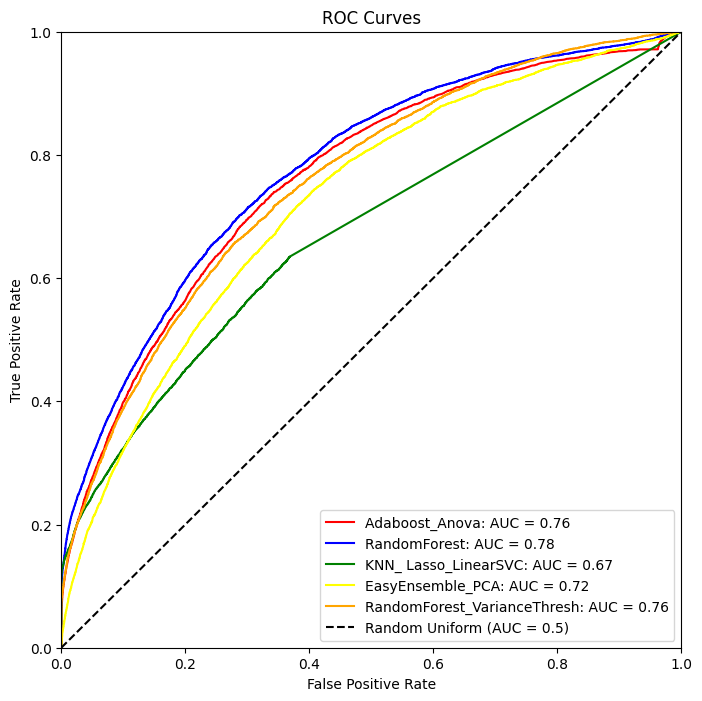

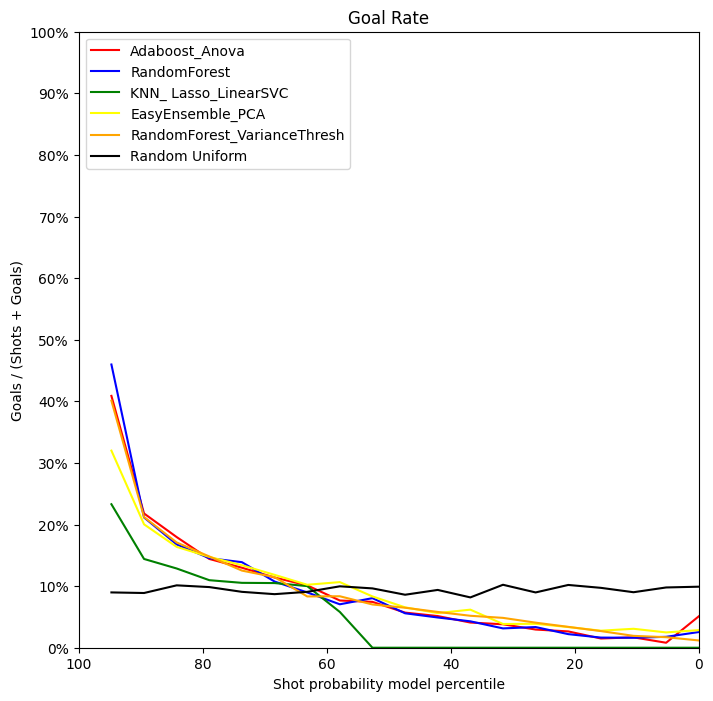

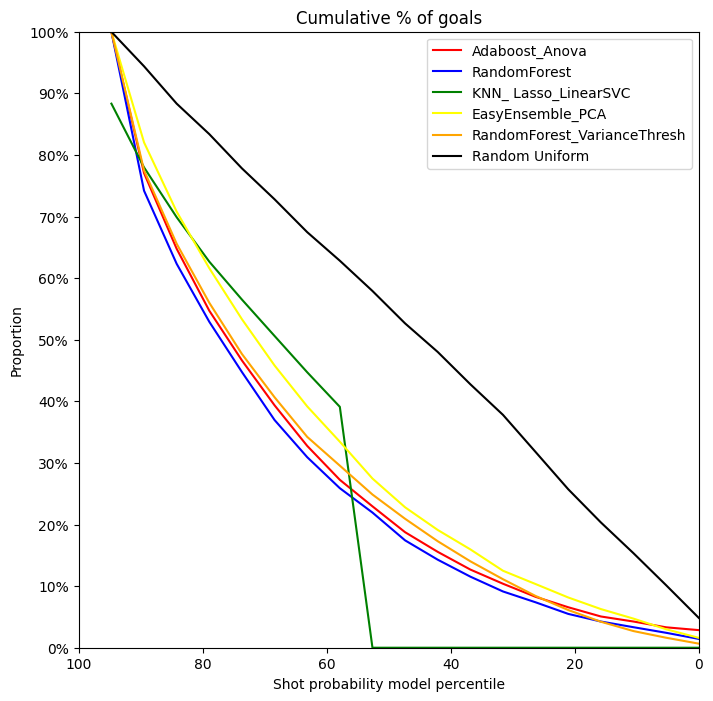

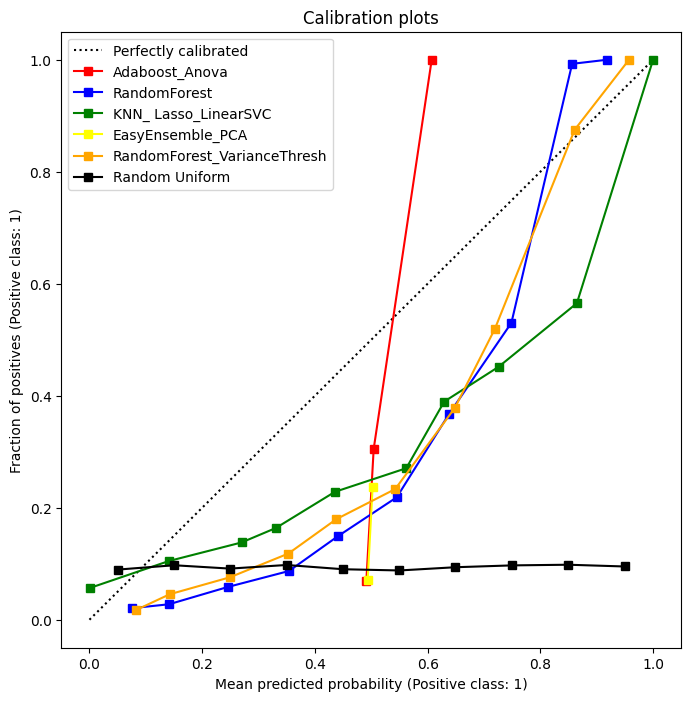

In [60]:
classifiers = [(clf_adaboost_anova, 'Adaboost_Anova', X_valid, y_valid),
               (clf_random_forest, 'RandomForest', X_valid, y_valid),
               (clf_knn, 'KNN_ Lasso_LinearSVC',X_valid, y_valid),
               (clf_easyensemble_pca, 'EasyEnsemble_PCA', X_valid, y_valid),
               (clf_forest_var, 'RandomForest_VarianceThresh', X_valid, y_valid)]

VizManager.plot_all_figures(classifiers, plot_name='Q6_Best_Models', add_random=True)

In [10]:
# Download the Adaboost / Anova - Calirbated
api.download_registry_model(workspace_name, "adaboost-anova-calibrated", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Adaboost_Anova_calibrated.pkl")
with open(pkl_filename, 'rb') as file:
    calibrated_clf_adaboost_anova = cloudpickle.load(file)
print(classification_report(y_valid, calibrated_clf_adaboost_anova.predict(X_valid)))

# Download the Random Forest
api.download_registry_model(workspace_name, "randomforest-allfeatures-calibrated", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "RandomForest_AllFeatures_calibrated.pkl")
with open(pkl_filename, 'rb') as file:
    calibrated_clf_random_forest = cloudpickle.load(file) 
print(classification_report(y_valid, calibrated_clf_random_forest.predict(X_valid)))

        
# Download the Knn / Linear SVC
api.download_registry_model(workspace_name, "knn-lasso-calibrated", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "KNN_Lasso_calibrated.pkl")
with open(pkl_filename, 'rb') as file:
    calibrated_clf_knn = cloudpickle.load(file)
print(classification_report(y_valid, calibrated_clf_knn.predict(X_valid)))

    
# Download the Easy Ensemble / PCA
api.download_registry_model(workspace_name, "easyensemble-pca-calibrated", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "EasyEnsemble_PCA_Calibrated.pkl")
with open(pkl_filename, 'rb') as file:
    calibrated_clf_easyensemble_pca = cloudpickle.load(file)
print(classification_report(y_valid, calibrated_clf_easyensemble_pca.predict(X_valid)))


# Download the Random Forest / Variance Threshold
api.download_registry_model(workspace_name, "forest-binning-shap-var-calibrated", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Forest_Binning_SHAP_Var_calibrated.pkl")
with open(pkl_filename, 'rb') as file:
    calibrated_clf_forest_var = cloudpickle.load(file)
print(classification_report(y_valid, calibrated_clf_forest_var.predict(X_valid)))


COMET INFO: Downloading registry model 'adaboost-anova-calibrated', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'randomforest-allfeatures-calibrated', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     55434
         1.0       0.33      0.32      0.33      5738

    accuracy                           0.87     61172
   macro avg       0.63      0.63      0.63     61172
weighted avg       0.87      0.87      0.87     61172



COMET INFO: done!
COMET INFO: Downloading registry model 'knn-lasso-calibrated', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55434
         1.0       0.76      0.15      0.25      5738

    accuracy                           0.92     61172
   macro avg       0.84      0.57      0.60     61172
weighted avg       0.90      0.92      0.89     61172



COMET INFO: done!
COMET INFO: Downloading registry model 'easyensemble-pca-calibrated', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55434
         1.0       0.97      0.12      0.22      5738

    accuracy                           0.92     61172
   macro avg       0.94      0.56      0.59     61172
weighted avg       0.92      0.92      0.89     61172



COMET INFO: done!
COMET INFO: Downloading registry model 'forest-binning-shap-var-calibrated', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     55434
         1.0       0.59      0.03      0.05      5738

    accuracy                           0.91     61172
   macro avg       0.75      0.51      0.50     61172
weighted avg       0.88      0.91      0.87     61172



COMET INFO: done!


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     55434
         1.0       0.77      0.10      0.17      5738

    accuracy                           0.91     61172
   macro avg       0.84      0.55      0.56     61172
weighted avg       0.90      0.91      0.88     61172



In [12]:
classifiers = [(calibrated_clf_adaboost_anova, 'Adaboost_Anova_Calibrated', X_valid, y_valid),
               (calibrated_clf_random_forest, 'RandomForest_Calibrated', X_valid, y_valid),
               (calibrated_clf_knn, 'KNN_Lasso_LinearSVC_Calibrated', X_valid, y_valid),
               (calibrated_clf_easyensemble_pca, 'EasyEnsemble_PCA_Calibrated', X_valid, y_valid),
               (calibrated_clf_forest_var, 'RandomForest_VarianceThresh_Calibrated', X_valid, y_valid)]


VizManager.plot_all_figures(classifiers, plot_name='Q6_Best_Models_Calibrated', add_random=True)

In [18]:
print(classification_report(y_valid, calibrated_clf_adaboost_anova.predict(X_valid)))
print(classification_report(y_valid, calibrated_clf_random_forest.predict(X_valid)))
print(classification_report(y_valid, calibrated_clf_knn.predict(X_valid)))
print(classification_report(y_valid, calibrated_clf_easyensemble_pca.predict(X_valid)))
print(classification_report(y_valid, calibrated_clf_forest_var.predict(X_valid)))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55433
         1.0       0.83      0.09      0.16      5574

    accuracy                           0.92     61007
   macro avg       0.87      0.54      0.56     61007
weighted avg       0.91      0.92      0.88     61007

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     55433
         1.0       0.83      0.16      0.27      5738

    accuracy                           0.92     61171
   macro avg       0.87      0.58      0.61     61171
weighted avg       0.91      0.92      0.89     61171

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55433
         1.0       1.00      1.00      1.00      5574

    accuracy                           1.00     61007
   macro avg       1.00      1.00      1.00     61007
weighted avg       1.00      1.00      1.00     61007

              preci